### Processing a video with *creme*

#### Get the data
Frames from the pure Cr experiment, referred to as video3_frames.zip (153 Mb), can be downloaded from [zenodo](https://doi.org/10.5281/zenodo.15436310). The data comprises one frame per second and should be placed into **data/media/video3/base**. First, use the **utils.dataset** module to generate the augmented data with a suitable field of view (in this case, FOV = 400 nm).

In [ ]:
# ATTENTION: this block will write approx. 500 Mb to your disk.
from utils.dataset import *

input_dir = 'data/media/video3/base'
output_dir = 'data/media/video3/base_aug'
# the flag resize=True assures crops are 512 x 512 px;
folder_fold_ij(input_dir, output_dir, 4, 4, resize=True)

#### Get the pre-trained model
The Mask-RCNN with ResNet50 weights (327 Mb) can be downloaded from the same [zenodo](https://doi.org/10.5281/zenodo.15436310) directory. Move the **model_final.pth** file to **output/ds25d_r50a_190325**. With data and model ready, we must generate predictions and compile them into an **analysis.csv** file. As a faster alternative, use the predict1c_r50a.py script.

In [ ]:
# ATTENTION: this block will write approx. 40 Mb to your disk.
from datetime import datetime

import pandas as pd

from detectron2.engine import DefaultPredictor

from core.models import get_train_cfg_r50a

# presets
job_name = 'ds25d_r50a_190325'
target_folder = Path("data/media/video3/base_aug/")
output_folder = target_folder / "masks"
os.makedirs(output_folder, exist_ok=True)
threshold = 0.80
save_masks = True

# backbone model
cfg = get_train_cfg_r50a(job_name, register_datasets=False)

# cfg presets
# -- cfg relative to the dataset
cfg.OUTPUT_DIR = f'output/{job_name}'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (threshold)  # testing threshold

# create a predictor
predictor = DefaultPredictor(cfg)
start = datetime.now()
main_df = pd.DataFrame() # to store all analytical data

# the loop can be edited depending on the data needed
for i, file in enumerate(target_folder.glob("*.png")):
    # this loop opens the .png files from the target folder, creates a dict with the file
    file = str(file)
    file_name = file.split("/")[-1]
    image_id = file_name.split(".png")[0]
    
    # -- preprocess
    im = cv2.imread(file) # simply load the image
    
    # prediction
    outputs = predictor(im)

    # get dimensions and create an empty mask
    height, width, channels = im.shape
    binary_mask = np.zeros((height, width, channels), dtype=np.uint8)
    
    contours = []
    for pred_mask in outputs['instances'].pred_masks:
        mask = pred_mask.cpu().numpy().astype('uint8') # convert (True, False) masks to 8-bit numpy array 
        contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)   
        try: 
            contours.append(contour[0]) # take the first element which is the array of contour points
        except:
            pass

    # plot contours and save image
    for contour in contours:
        cv2.drawContours(binary_mask, [contour], -1, (255,255,255), thickness=cv2.FILLED) 


    if save_masks:
        if contours: 
            # contours must not be empty
            cv2.imwrite(f"{output_folder}/{file_name}", binary_mask)
    else:
        cv2.imshow('Binary Mask', binary_mask)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    
    # analysis section
    ellipse_data = []
    
    for i, contour in enumerate(contours):
        # Fit an ellipse to the contour
        if len(contour) >= 5:  # fitEllipse requires at least 5 points
            ellipse = cv2.fitEllipse(contour)
            center, axes, angle = ellipse
            major_axis_length = max(axes)
            minor_axis_length = min(axes)

            center_str = f"({center[0]:.3f} - {center[1]:.3f})" # tuple to str to avoid error when exp

            # Append the data to the list
            ellipse_data.append({
                'image_id': image_id,
                'id': i,
                'center': center_str,
                'major_axis': major_axis_length,
                'minor_axis': minor_axis_length,
                'angle': angle
            })
        
    df = pd.DataFrame(ellipse_data)
    
    # append the current DataFrame to the main DataFrame
    main_df = pd.concat([main_df, df], ignore_index=True)


export_file = os.path.join(output_folder, 'analysis.csv')
main_df.to_csv(export_file, sep='\t', encoding='utf-8', index=False, header=True)

print("Time needed for running:", datetime.now() - start)


/home/camilofs/miniforge3/envs/py39d2/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loc

Time needed for running: 0:05:46.801456


### Plot the data
It is time to plot the data based on the **analysis.csv** file. For example, you can reproduce Figure 8 from the reference paper using the following block.


78 time instances...


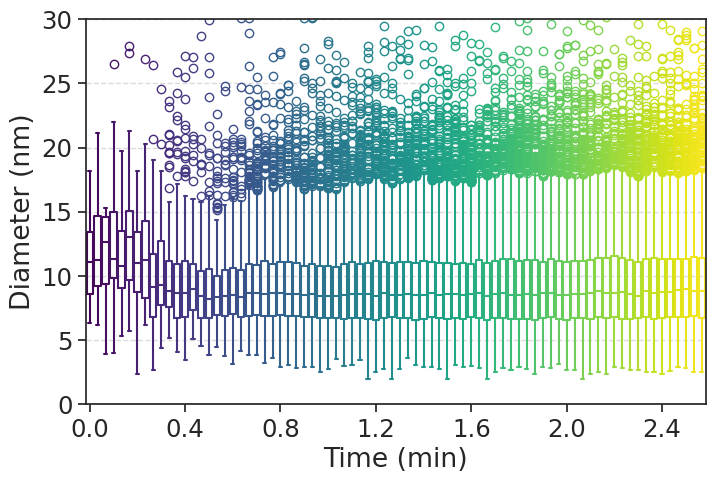

   time  total_count_sum  total_count_std
0  0.00               26         1.804036
1  0.03               14         1.752549
2  0.07               19         1.685018
3  0.10               25         1.934836
4  0.13               28         1.874874
Area of each image: 2.5600000000000004e-12 m^2


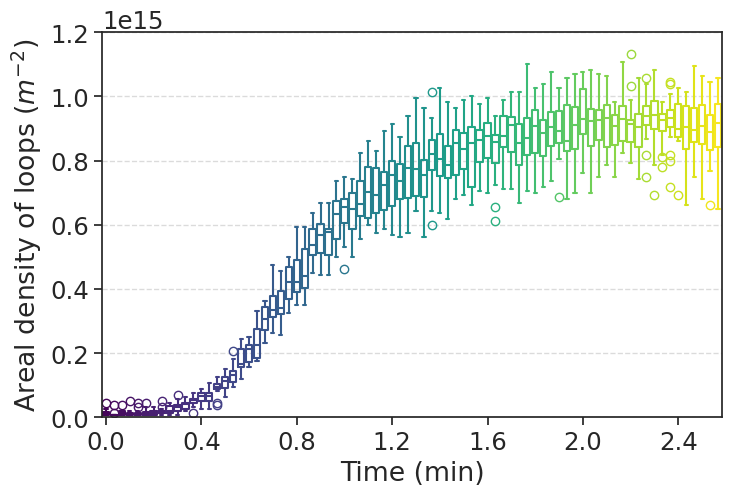

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -- presets 
palette = sns.mpl_palette("viridis", 78) # or None

save_images = False
input1 = 'data/media/video3/base_aug/masks/analysis.csv'
df = pd.read_csv(input1, sep='\t')

df[['image_id', 'subset']] = df['image_id'].str.split('s_', expand=True)

# Function to convert image_id to total minutes
def convert_to_timedelta(image_id):
    # Extract minutes and seconds using regex
    match = pd.Series(image_id).str.extract(r'(\d+)m_(\d+)')
    
    # Convert extracted values to integers
    minute = int(match[0][0])
    second = int(match[1][0])
    
    # Calculate total minutes
    total_minutes = minute + second / 60
    
    return np.round(total_minutes, 2) # mod JA

# Apply function to the image_id column to get time in seconds
df['time'] = df['image_id'].apply(convert_to_timedelta)

# reduced data
selected_times = df['time'].unique()[::2]
fdf = df[df['time'].isin(selected_times)]
t = fdf['time'].nunique()
print(f'{t} time instances...') # use it to adjust the palette 

# set correct scale
spatial_scale = 1600 / 2048 # nm / px


# correct dimensions
fdf = fdf.assign(
    diameter=((fdf['major_axis'] * spatial_scale) + (fdf['minor_axis'] * spatial_scale)) / 2
).query('2 <= diameter <= 40').copy()

# -- Plotting the boxplot for sizes
plt.figure(figsize=(8, 5)) # mod Jupyter
sns.set(font_scale=1.6) # mod Jupyter
sns.set_style("ticks")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Enables horizontal grid lines
sns.boxplot(x='time', y='diameter', data=fdf, 
            hue='time', fill=False,
            palette=palette)
            
# plt.title('video 3 (b)')
plt.xlabel('Time (min)')
plt.ylabel('Diameter (nm)')
plt.ylim([0, 30])
plt.legend([],[], frameon=False)

plt.xticks(np.arange(0, 80, 12))
# plt.xticks([4, 10, 16, 22, 28, 34, 40, 46]) # custom ticks 

if save_images:
    plt.savefig('output/video3_size.png')
else:
    plt.show()

# Initialize an empty list to store results
result = []

# Group by image_id and subset and iterate over each group
for (time, subset), group in fdf.groupby(['time', 'subset']):
    total_count = len(group)
    result.append({'time': time, 'subset': subset, 'total_count': total_count})

# Convert the result list to a DataFrame
rdf = pd.DataFrame(result)
rdf = rdf.iloc[rdf['time'].astype(int).argsort()]

# -- prepare data for posterior analysis
# Group by 'time' and calculate both sum and standard deviation for 'n_density'
rdf_gd = rdf.groupby('time', as_index=False).agg({
    'total_count': ['sum', 'std']
})

# Flatten the column names after aggregation
rdf_gd.columns = ['time', 'total_count_sum', 'total_count_std']
print (rdf_gd.head())

# get the dislocation (numeric) density 
a = 2048 * spatial_scale * 1e-9 # 1-dim (in m)
A = a*a # Area
print (f'Area of each image: {A} m^2')
rdf['n_density'] = rdf['total_count'] / A

rdf_gd['n_density_sum'] = rdf_gd['total_count_sum'] / A
rdf_gd['n_density_std'] = rdf_gd['total_count_std'] / A

# correct dimensions (since it has not being grouped by time)
rdf['n_density'] = rdf['n_density'] * 16

# Plotting the 2nd boxplot
plt.figure(figsize=(8, 5)) # mod Jupyter
sns.set(font_scale=1.6) # mod Jupyter
sns.set_style("ticks")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Enables horizontal grid lines
sns.boxplot(x='time', y='n_density', data=rdf, 
            hue='time', fill=False, 
            palette=palette)
            
# plt.title('video 3 (a)')
plt.xlabel('Time (min)')
# plt.yscale('log')
plt.ylabel('Areal density of loops ($m^{-2}$)')
plt.ylim([0, 1.2e15])
plt.legend([],[], frameon=False)

plt.xticks(np.arange(0, 80, 12))
# plt.xticks([4, 10, 16, 22, 28, 34, 40, 46])

if save_images:
    plt.savefig('output/video3_density.png')
else:
    plt.show()